In [1]:
import tensorflow as tf
from tensorflow import keras as keras
print(tf.__version__)

print(keras.__version__)

2.3.1
2.4.0


In [2]:
# Wczytaj dane treningowe i testowe
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

train_set = pd.read_csv('Dane/adult/adult.data', sep=", ",header = None)
test_set = pd.read_csv('Dane/adult/adult.test', sep=", ",skiprows = 1, header = None) # Make sure to skip a row for the test set

col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 
              'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
             'wage_class']
train_set.columns = col_labels
test_set.columns = col_labels

train = train_set.replace('?', np.nan).dropna()
test = test_set.replace('?', np.nan).dropna()

train_set.head()

C:\Users\admin\anaconda3\lib\site-packages\ipykernel_launcher.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  
C:\Users\admin\anaconda3\lib\site-packages\ipykernel_launcher.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  import sys


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
dataset = pd.concat([train,test])

dataset['wage_class'] = dataset.wage_class.replace({'<=50K.': 0,'<=50K':0, '>50K.':1, '>50K':1})

dataset.drop(["fnlwgt"],axis=1,inplace=True)

dataset.drop(["education"],axis=1,inplace=True)

x = dataset.groupby('native_country')["wage_class"].mean()

d = dict(pd.cut(x[x.index!=" United-States"],5,labels=range(5)))

dataset['native_country'] = dataset['native_country'].replace(d)

dataset = pd.get_dummies(dataset,drop_first=True)

train = dataset.iloc[:train.shape[0]]
test = dataset.iloc[train.shape[0]:]

X_train = train.drop("wage_class",axis=1)
y_train = train.wage_class

X_test = test.drop("wage_class",axis=1)
y_test = test.wage_class

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

print(X_train.shape)
X_test.shape

(30162, 41)


(15060, 41)

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation

from tensorflow.keras.callbacks import History

# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.0001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * np.power(drop, np.floor((1+epoch)/epochs_drop))
    return lrate


history_Adam = History()
model = Sequential()
model.add(Dense(100, use_bias=False,input_shape=(X_train.shape[1],)))
model.add(BatchNormalization())
model.add(Activation("sigmoid"))
model.add(Dropout(0.3))
model.add(Dense(50, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("sigmoid"))
model.add(Dropout(0.3))
model.add(Dense(10, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("sigmoid"))
model.add(Dropout(0.3))
model.add(Dense(1,activation="sigmoid"))
model.summary()

Adam = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss="binary_crossentropy",optimizer=Adam, metrics=["accuracy"])

lrate = LearningRateScheduler(step_decay)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)
model.fit(X_train, y_train, validation_data= (X_test, y_test), batch_size=32,epochs=100, callbacks=[lrate, history_Adam, early_stopping])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               4100      
_________________________________________________________________
batch_normalization (BatchNo (None, 100)               400       
_________________________________________________________________
activation (Activation)      (None, 100)               0         
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5000      
_________________________________________________________________
batch_normalization_1 (Batch (None, 50)                200       
_________________________________________________________________
activation_1 (Activation)    (None, 50)                0

943/943 [==============================] - 2s 2ms/step - loss: 0.3820 - accuracy: 0.8187 - val_loss: 0.3440 - val_accuracy: 0.8456
Epoch 44/100
943/943 [==============================] - 2s 2ms/step - loss: 0.3841 - accuracy: 0.8156 - val_loss: 0.3436 - val_accuracy: 0.8461
Epoch 45/100
943/943 [==============================] - 2s 2ms/step - loss: 0.3815 - accuracy: 0.8181 - val_loss: 0.3439 - val_accuracy: 0.8446
Epoch 46/100
943/943 [==============================] - 2s 2ms/step - loss: 0.3805 - accuracy: 0.8185 - val_loss: 0.3439 - val_accuracy: 0.8459
Epoch 47/100
943/943 [==============================] - 2s 2ms/step - loss: 0.3859 - accuracy: 0.8169 - val_loss: 0.3439 - val_accuracy: 0.8445
Epoch 48/100
943/943 [==============================] - 2s 2ms/step - loss: 0.3848 - accuracy: 0.8155 - val_loss: 0.3440 - val_accuracy: 0.8454
Epoch 49/100
943/943 [==============================] - 2s 2ms/step - loss: 0.3833 - accuracy: 0.8170 - val_loss: 0.3438 - val_accuracy: 0.8444
Epoch

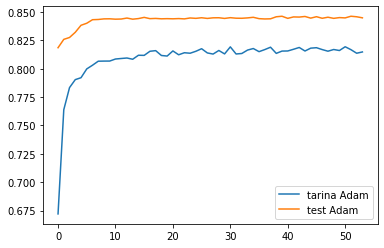

In [5]:
plt.plot(history_Adam.history['accuracy'], label = "tarina Adam")
plt.plot(history_Adam.history['val_accuracy'], label = "test Adam")


plt.legend()
plt.show()

# Zad.
Do poniższego modelu dodaj
 
```python
model.add(BatchNormalization())
model.add(Activation("sigmoid"))
model.add(Dropout(0.3))
```

w każdej warstwie.

Zwizualizuj wyniki dla obu modeli.

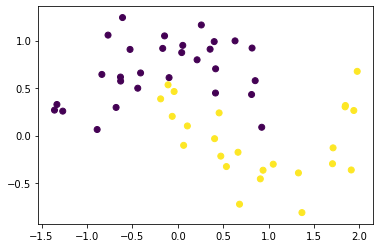

In [6]:
from sklearn.datasets import make_moons
# generate 2d classification dataset
X, y = make_moons(n_samples=100, noise=0.2, random_state=5)
# split into train and test
# n_train = 30
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.70, random_state=2)

n_train=53
X_train, X_test = X[:n_train, :], X[n_train:, :]
y_train, y_test = y[:n_train], y[n_train:]

plt.scatter(X_train[:,0],X_train[:,1], c=y_train)
plt.show()

In [7]:
from tensorflow.keras.callbacks import History


history_Adam = History()
model = Sequential()
model.add(Dense(1000,activation="relu",input_shape=(X_train.shape[1],)))
model.add(Dense(500,activation="sigmoid"))
model.add(Dense(200,activation="sigmoid"))
model.add(Dense(1,activation="sigmoid"))
model.summary()

model.compile(loss="binary_crossentropy",optimizer="adam", metrics=["accuracy"])

lrate = LearningRateScheduler(step_decay)
model.fit(X_train, y_train, validation_data= (X_test, y_test), epochs=1000, callbacks=[history_Adam])


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1000)              3000      
_________________________________________________________________
dense_5 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_6 (Dense)              (None, 200)               100200    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 201       
Total params: 603,901
Trainable params: 603,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
2/2 [==============================] - 0s 57ms/step - loss: 0.8319 - accuracy: 0.5472 - val_loss: 0.6738 - val_accuracy: 0.5532
Epoch 2/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.6917 - accuracy: 0.4528 - val_

2/2 [==============================] - 0s 12ms/step - loss: 0.1877 - accuracy: 0.9245 - val_loss: 0.5056 - val_accuracy: 0.8085
Epoch 53/1000
2/2 [==============================] - 0s 12ms/step - loss: 0.1854 - accuracy: 0.9434 - val_loss: 0.4891 - val_accuracy: 0.8298
Epoch 54/1000
2/2 [==============================] - 0s 12ms/step - loss: 0.1819 - accuracy: 0.9245 - val_loss: 0.4569 - val_accuracy: 0.8298
Epoch 55/1000
2/2 [==============================] - 0s 11ms/step - loss: 0.1812 - accuracy: 0.9245 - val_loss: 0.4430 - val_accuracy: 0.8298
Epoch 56/1000
2/2 [==============================] - 0s 12ms/step - loss: 0.1817 - accuracy: 0.9245 - val_loss: 0.4456 - val_accuracy: 0.8298
Epoch 57/1000
2/2 [==============================] - 0s 19ms/step - loss: 0.1780 - accuracy: 0.9245 - val_loss: 0.4723 - val_accuracy: 0.8298
Epoch 58/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.1745 - accuracy: 0.9434 - val_loss: 0.4780 - val_accuracy: 0.8298
Epoch 59/1000
2/2 [=

2/2 [==============================] - 0s 13ms/step - loss: 0.0638 - accuracy: 0.9811 - val_loss: 0.2221 - val_accuracy: 0.9149
Epoch 110/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0638 - accuracy: 0.9811 - val_loss: 0.2070 - val_accuracy: 0.9149
Epoch 111/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0610 - accuracy: 1.0000 - val_loss: 0.2044 - val_accuracy: 0.9149
Epoch 112/1000
2/2 [==============================] - 0s 12ms/step - loss: 0.0579 - accuracy: 1.0000 - val_loss: 0.2112 - val_accuracy: 0.9149
Epoch 113/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0571 - accuracy: 0.9811 - val_loss: 0.2115 - val_accuracy: 0.9149
Epoch 114/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.0584 - accuracy: 0.9623 - val_loss: 0.2079 - val_accuracy: 0.9149
Epoch 115/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.0526 - accuracy: 1.0000 - val_loss: 0.1893 - val_accuracy: 0.9149
Epoch 116/1000

2/2 [==============================] - 0s 13ms/step - loss: 0.0182 - accuracy: 1.0000 - val_loss: 0.1931 - val_accuracy: 0.9362
Epoch 167/1000
2/2 [==============================] - 0s 12ms/step - loss: 0.0193 - accuracy: 1.0000 - val_loss: 0.1993 - val_accuracy: 0.9362
Epoch 168/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0184 - accuracy: 1.0000 - val_loss: 0.1980 - val_accuracy: 0.9362
Epoch 169/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0180 - accuracy: 1.0000 - val_loss: 0.1944 - val_accuracy: 0.9362
Epoch 170/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0172 - accuracy: 1.0000 - val_loss: 0.1890 - val_accuracy: 0.9149
Epoch 171/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.0170 - accuracy: 1.0000 - val_loss: 0.1869 - val_accuracy: 0.9149
Epoch 172/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.0179 - accuracy: 1.0000 - val_loss: 0.1877 - val_accuracy: 0.9149
Epoch 173/1000

2/2 [==============================] - 0s 13ms/step - loss: 0.0086 - accuracy: 1.0000 - val_loss: 0.1978 - val_accuracy: 0.9362
Epoch 224/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.0081 - accuracy: 1.0000 - val_loss: 0.2018 - val_accuracy: 0.9362
Epoch 225/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.0082 - accuracy: 1.0000 - val_loss: 0.2049 - val_accuracy: 0.9362
Epoch 226/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.0085 - accuracy: 1.0000 - val_loss: 0.2057 - val_accuracy: 0.9362
Epoch 227/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.0087 - accuracy: 1.0000 - val_loss: 0.2035 - val_accuracy: 0.9362
Epoch 228/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.0080 - accuracy: 1.0000 - val_loss: 0.2007 - val_accuracy: 0.9149
Epoch 229/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.0088 - accuracy: 1.0000 - val_loss: 0.1978 - val_accuracy: 0.9149
Epoch 230/1000

2/2 [==============================] - 0s 18ms/step - loss: 0.0051 - accuracy: 1.0000 - val_loss: 0.2137 - val_accuracy: 0.9149
Epoch 281/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.2132 - val_accuracy: 0.9149
Epoch 282/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.2136 - val_accuracy: 0.9149
Epoch 283/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.2143 - val_accuracy: 0.9149
Epoch 284/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.0048 - accuracy: 1.0000 - val_loss: 0.2152 - val_accuracy: 0.9149
Epoch 285/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.2161 - val_accuracy: 0.9149
Epoch 286/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.2173 - val_accuracy: 0.9149
Epoch 287/1000

2/2 [==============================] - 0s 14ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.2375 - val_accuracy: 0.9149
Epoch 338/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.2379 - val_accuracy: 0.9149
Epoch 339/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.2383 - val_accuracy: 0.9149
Epoch 340/1000
2/2 [==============================] - 0s 12ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.2388 - val_accuracy: 0.9149
Epoch 341/1000
2/2 [==============================] - 0s 12ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.2383 - val_accuracy: 0.9149
Epoch 342/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.2382 - val_accuracy: 0.9149
Epoch 343/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.2379 - val_accuracy: 0.9149
Epoch 344/1000

2/2 [==============================] - 0s 14ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.2590 - val_accuracy: 0.9149
Epoch 395/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.2595 - val_accuracy: 0.9149
Epoch 396/1000
2/2 [==============================] - 0s 12ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.2589 - val_accuracy: 0.9149
Epoch 397/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.2590 - val_accuracy: 0.9149
Epoch 398/1000
2/2 [==============================] - 0s 12ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.2586 - val_accuracy: 0.9362
Epoch 399/1000
2/2 [==============================] - 0s 12ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.2586 - val_accuracy: 0.9362
Epoch 400/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.2587 - val_accuracy: 0.9362
Epoch 401/1000

2/2 [==============================] - 0s 12ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.2857 - val_accuracy: 0.9149
Epoch 452/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.2859 - val_accuracy: 0.9149
Epoch 453/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.2865 - val_accuracy: 0.8936
Epoch 454/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.2873 - val_accuracy: 0.8936
Epoch 455/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.2879 - val_accuracy: 0.8936
Epoch 456/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.2888 - val_accuracy: 0.8936
Epoch 457/1000
2/2 [==============================] - 0s 12ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.2893 - val_accuracy: 0.8936
Epoch 458/1000

2/2 [==============================] - 0s 12ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.3163 - val_accuracy: 0.8936
Epoch 509/1000
2/2 [==============================] - 0s 14ms/step - loss: 9.6723e-04 - accuracy: 1.0000 - val_loss: 0.3168 - val_accuracy: 0.8936
Epoch 510/1000
2/2 [==============================] - 0s 13ms/step - loss: 9.5417e-04 - accuracy: 1.0000 - val_loss: 0.3176 - val_accuracy: 0.9149
Epoch 511/1000
2/2 [==============================] - 0s 13ms/step - loss: 9.4861e-04 - accuracy: 1.0000 - val_loss: 0.3182 - val_accuracy: 0.9149
Epoch 512/1000
2/2 [==============================] - 0s 12ms/step - loss: 9.8202e-04 - accuracy: 1.0000 - val_loss: 0.3188 - val_accuracy: 0.9149
Epoch 513/1000
2/2 [==============================] - 0s 12ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.3189 - val_accuracy: 0.9149
Epoch 514/1000
2/2 [==============================] - 0s 12ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.3192 - val_accuracy: 0.914

Epoch 564/1000
2/2 [==============================] - 0s 15ms/step - loss: 7.4215e-04 - accuracy: 1.0000 - val_loss: 0.3437 - val_accuracy: 0.9149
Epoch 565/1000
2/2 [==============================] - 0s 12ms/step - loss: 7.3049e-04 - accuracy: 1.0000 - val_loss: 0.3440 - val_accuracy: 0.9149
Epoch 566/1000
2/2 [==============================] - 0s 13ms/step - loss: 7.2638e-04 - accuracy: 1.0000 - val_loss: 0.3444 - val_accuracy: 0.9149
Epoch 567/1000
2/2 [==============================] - 0s 13ms/step - loss: 7.2282e-04 - accuracy: 1.0000 - val_loss: 0.3450 - val_accuracy: 0.9149
Epoch 568/1000
2/2 [==============================] - 0s 13ms/step - loss: 7.2179e-04 - accuracy: 1.0000 - val_loss: 0.3454 - val_accuracy: 0.9149
Epoch 569/1000
2/2 [==============================] - 0s 13ms/step - loss: 7.2017e-04 - accuracy: 1.0000 - val_loss: 0.3459 - val_accuracy: 0.9149
Epoch 570/1000
2/2 [==============================] - 0s 12ms/step - loss: 7.1708e-04 - accuracy: 1.0000 - val_loss: 0

Epoch 620/1000
2/2 [==============================] - 0s 13ms/step - loss: 5.8688e-04 - accuracy: 1.0000 - val_loss: 0.3678 - val_accuracy: 0.9149
Epoch 621/1000
2/2 [==============================] - 0s 16ms/step - loss: 5.9716e-04 - accuracy: 1.0000 - val_loss: 0.3682 - val_accuracy: 0.9149
Epoch 622/1000
2/2 [==============================] - 0s 16ms/step - loss: 5.6877e-04 - accuracy: 1.0000 - val_loss: 0.3685 - val_accuracy: 0.9149
Epoch 623/1000
2/2 [==============================] - 0s 12ms/step - loss: 6.0563e-04 - accuracy: 1.0000 - val_loss: 0.3690 - val_accuracy: 0.9149
Epoch 624/1000
2/2 [==============================] - 0s 13ms/step - loss: 5.6946e-04 - accuracy: 1.0000 - val_loss: 0.3696 - val_accuracy: 0.8936
Epoch 625/1000
2/2 [==============================] - 0s 13ms/step - loss: 5.9500e-04 - accuracy: 1.0000 - val_loss: 0.3703 - val_accuracy: 0.8936
Epoch 626/1000
2/2 [==============================] - 0s 18ms/step - loss: 5.7422e-04 - accuracy: 1.0000 - val_loss: 0

Epoch 676/1000
2/2 [==============================] - 0s 12ms/step - loss: 4.5665e-04 - accuracy: 1.0000 - val_loss: 0.3892 - val_accuracy: 0.9149
Epoch 677/1000
2/2 [==============================] - 0s 13ms/step - loss: 4.6947e-04 - accuracy: 1.0000 - val_loss: 0.3895 - val_accuracy: 0.9149
Epoch 678/1000
2/2 [==============================] - 0s 15ms/step - loss: 4.6097e-04 - accuracy: 1.0000 - val_loss: 0.3897 - val_accuracy: 0.9149
Epoch 679/1000
2/2 [==============================] - 0s 15ms/step - loss: 4.5261e-04 - accuracy: 1.0000 - val_loss: 0.3902 - val_accuracy: 0.9149
Epoch 680/1000
2/2 [==============================] - 0s 18ms/step - loss: 4.4980e-04 - accuracy: 1.0000 - val_loss: 0.3905 - val_accuracy: 0.9149
Epoch 681/1000
2/2 [==============================] - 0s 14ms/step - loss: 4.5097e-04 - accuracy: 1.0000 - val_loss: 0.3906 - val_accuracy: 0.9149
Epoch 682/1000
2/2 [==============================] - 0s 18ms/step - loss: 4.5558e-04 - accuracy: 1.0000 - val_loss: 0

Epoch 732/1000
2/2 [==============================] - 0s 13ms/step - loss: 3.7191e-04 - accuracy: 1.0000 - val_loss: 0.4086 - val_accuracy: 0.9149
Epoch 733/1000
2/2 [==============================] - 0s 15ms/step - loss: 3.7196e-04 - accuracy: 1.0000 - val_loss: 0.4091 - val_accuracy: 0.9149
Epoch 734/1000
2/2 [==============================] - 0s 17ms/step - loss: 3.8270e-04 - accuracy: 1.0000 - val_loss: 0.4095 - val_accuracy: 0.9149
Epoch 735/1000
2/2 [==============================] - 0s 14ms/step - loss: 3.7069e-04 - accuracy: 1.0000 - val_loss: 0.4097 - val_accuracy: 0.9149
Epoch 736/1000
2/2 [==============================] - 0s 14ms/step - loss: 3.6639e-04 - accuracy: 1.0000 - val_loss: 0.4099 - val_accuracy: 0.9149
Epoch 737/1000
2/2 [==============================] - 0s 16ms/step - loss: 3.7870e-04 - accuracy: 1.0000 - val_loss: 0.4101 - val_accuracy: 0.9149
Epoch 738/1000
2/2 [==============================] - 0s 13ms/step - loss: 3.7113e-04 - accuracy: 1.0000 - val_loss: 0

Epoch 788/1000
2/2 [==============================] - 0s 13ms/step - loss: 3.1663e-04 - accuracy: 1.0000 - val_loss: 0.4264 - val_accuracy: 0.9149
Epoch 789/1000
2/2 [==============================] - 0s 13ms/step - loss: 3.0720e-04 - accuracy: 1.0000 - val_loss: 0.4267 - val_accuracy: 0.9149
Epoch 790/1000
2/2 [==============================] - 0s 18ms/step - loss: 3.0588e-04 - accuracy: 1.0000 - val_loss: 0.4270 - val_accuracy: 0.9149
Epoch 791/1000
2/2 [==============================] - 0s 16ms/step - loss: 3.0535e-04 - accuracy: 1.0000 - val_loss: 0.4274 - val_accuracy: 0.9149
Epoch 792/1000
2/2 [==============================] - 0s 16ms/step - loss: 3.0943e-04 - accuracy: 1.0000 - val_loss: 0.4277 - val_accuracy: 0.9149
Epoch 793/1000
2/2 [==============================] - 0s 13ms/step - loss: 3.1269e-04 - accuracy: 1.0000 - val_loss: 0.4281 - val_accuracy: 0.9149
Epoch 794/1000
2/2 [==============================] - 0s 12ms/step - loss: 3.0672e-04 - accuracy: 1.0000 - val_loss: 0

Epoch 844/1000
2/2 [==============================] - 0s 12ms/step - loss: 2.6011e-04 - accuracy: 1.0000 - val_loss: 0.4424 - val_accuracy: 0.9149
Epoch 845/1000
2/2 [==============================] - 0s 17ms/step - loss: 2.6296e-04 - accuracy: 1.0000 - val_loss: 0.4426 - val_accuracy: 0.9149
Epoch 846/1000
2/2 [==============================] - 0s 13ms/step - loss: 2.5963e-04 - accuracy: 1.0000 - val_loss: 0.4428 - val_accuracy: 0.9149
Epoch 847/1000
2/2 [==============================] - 0s 15ms/step - loss: 2.6640e-04 - accuracy: 1.0000 - val_loss: 0.4429 - val_accuracy: 0.9149
Epoch 848/1000
2/2 [==============================] - 0s 30ms/step - loss: 2.5976e-04 - accuracy: 1.0000 - val_loss: 0.4429 - val_accuracy: 0.9149
Epoch 849/1000
2/2 [==============================] - 0s 16ms/step - loss: 2.5662e-04 - accuracy: 1.0000 - val_loss: 0.4430 - val_accuracy: 0.9149
Epoch 850/1000
2/2 [==============================] - 0s 12ms/step - loss: 2.6615e-04 - accuracy: 1.0000 - val_loss: 0

Epoch 900/1000
2/2 [==============================] - 0s 16ms/step - loss: 2.2406e-04 - accuracy: 1.0000 - val_loss: 0.4565 - val_accuracy: 0.9149
Epoch 901/1000
2/2 [==============================] - 0s 17ms/step - loss: 2.2031e-04 - accuracy: 1.0000 - val_loss: 0.4569 - val_accuracy: 0.9149
Epoch 902/1000
2/2 [==============================] - 0s 19ms/step - loss: 2.1874e-04 - accuracy: 1.0000 - val_loss: 0.4570 - val_accuracy: 0.9149
Epoch 903/1000
2/2 [==============================] - 0s 19ms/step - loss: 2.2648e-04 - accuracy: 1.0000 - val_loss: 0.4572 - val_accuracy: 0.9149
Epoch 904/1000
2/2 [==============================] - 0s 16ms/step - loss: 2.2319e-04 - accuracy: 1.0000 - val_loss: 0.4575 - val_accuracy: 0.9149
Epoch 905/1000
2/2 [==============================] - 0s 14ms/step - loss: 2.2586e-04 - accuracy: 1.0000 - val_loss: 0.4578 - val_accuracy: 0.9149
Epoch 906/1000
2/2 [==============================] - 0s 15ms/step - loss: 2.2130e-04 - accuracy: 1.0000 - val_loss: 0

Epoch 956/1000
2/2 [==============================] - 0s 15ms/step - loss: 1.8858e-04 - accuracy: 1.0000 - val_loss: 0.4683 - val_accuracy: 0.9149
Epoch 957/1000
2/2 [==============================] - 0s 13ms/step - loss: 1.8819e-04 - accuracy: 1.0000 - val_loss: 0.4687 - val_accuracy: 0.9149
Epoch 958/1000
2/2 [==============================] - 0s 12ms/step - loss: 1.8876e-04 - accuracy: 1.0000 - val_loss: 0.4689 - val_accuracy: 0.9149
Epoch 959/1000
2/2 [==============================] - 0s 12ms/step - loss: 1.9004e-04 - accuracy: 1.0000 - val_loss: 0.4692 - val_accuracy: 0.9149
Epoch 960/1000
2/2 [==============================] - 0s 12ms/step - loss: 1.9129e-04 - accuracy: 1.0000 - val_loss: 0.4694 - val_accuracy: 0.9149
Epoch 961/1000
2/2 [==============================] - 0s 13ms/step - loss: 1.8997e-04 - accuracy: 1.0000 - val_loss: 0.4696 - val_accuracy: 0.9149
Epoch 962/1000
2/2 [==============================] - 0s 12ms/step - loss: 1.8837e-04 - accuracy: 1.0000 - val_loss: 0

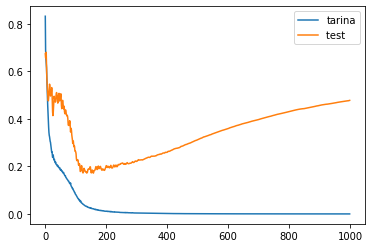

In [8]:
plt.plot(history_Adam.history['loss'], label = "tarina")
plt.plot(history_Adam.history['val_loss'], label = "test ")


plt.legend()
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


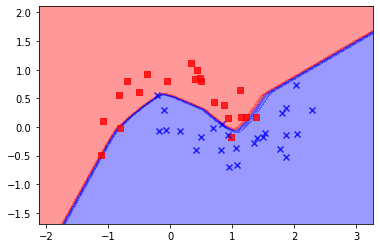

In [9]:
from help_plot import plot_decision_regions
plot_decision_regions(X_test, y_test, model)
plt.show()